In [1]:
import pprint

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

from dynamic_custom_mean import Flatten

## Definition of Objective

In [2]:
# load Xopt vocs
vocs = VOCS.from_yaml(open("vocs.yaml").read())
print(vocs.as_yaml())

variables:
  distgen:r_dist:sigma_xy:value: [0.21021247820852546, 0.4999996083265339]
  distgen:t_dist:length:value: [3.000000758511308, 11.998569812014836]
  SOL1:solenoid_field_scale: [0.19409053333889578, 0.2563030896232562]
  CQ01:b1_gradient: [-0.009999618141995313, 0.0099925212795954]
  SQ01:b1_gradient: [-0.009999490058927914, 0.009999443099573097]
  L0A_phase:dtheta0_deg: [-24.998714513984325, 9.991752397382681]
  L0B_phase:dtheta0_deg: [-24.99972566363747, 9.998904767155892]
  QA01:b1_gradient: [1.000039854940649, 3.998197816908352]
  QA02:b1_gradient: [-3.990444304119449, -1.0105116218007806]
  QE01:b1_gradient: [1.0007061999094193, 6.9997773994714345]
  QE02:b1_gradient: [-6.999887318319171, 0.9983521010385275]
  QE03:b1_gradient: [-6.998418428856965, 0.9993010487139868]
  QE04:b1_gradient: [1.000026533968218, 6.998086093251312]
constraints: {}
objectives: {sigma_xy: MINIMIZE}
constants: {'distgen:total_charge:value': 250.0, 'L0A_scale:voltage': 58000000.0,
  'L0B_scale:volt

In [3]:
# load NN prior model
input_transformer = torch.load("model/input_transformer.pt")
output_transformer = torch.load("model/output_transformer.pt")
input_variables, output_variables = variables_from_yaml(open("model/variables.yml"))
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_transformer],
    output_transformers=[output_transformer],
)
# wrap in lume module
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs,
)

In [4]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2) * 1e3  # in mm

    def forward(self, x):
        idx_sigma_x = self.model.output_order.index("sigma_x")
        idx_sigma_y = self.model.output_order.index("sigma_y")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [5]:
# Xopt evaluator function
def evaluate(input_dict):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["sigma_x"], model_result["sigma_y"])
    return {vocs.objective_names[0]: sigma_xy.detach().item()}

## Definition of Custom Mean and Xopt

In [6]:
# define custom mean
mean_class = Flatten
mean_kwargs = {"step": 0, "w_lim": (0.0, 1.0), "step_range": (0, 10)}
n_epoch = 10  # determines which correlated model is used

# load correlated NN prior model
input_transformer = torch.load("corr_models/input_transformer.pt")
output_transformer = torch.load("corr_models/output_transformer.pt")
corr_model = PyTorchModel(
    model_file="corr_models/{:d}ep.pt".format(n_epoch),
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_transformer],
    output_transformers=[output_transformer],
)

# wrap in lume module
corr_module = LUMEModule(
    model=corr_model, 
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs,
)
mean_kwargs["model"] = ObjectiveModel(corr_module)

In [7]:
# Xopt definition
model_constructor = StandardModelConstructor(
    mean_modules={vocs.objective_names[0]: mean_class(**mean_kwargs)},
    trainable_mean_keys=[vocs.objective_names[0]],
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

In [8]:
# create initial samples
n_init = 3
X.random_evaluate(n_samples=n_init)

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.340961,7.095401,0.229080,0.002327,-0.001361,6.943058,-17.235516,1.602194,-1.362961,1.332641,-1.117627,-3.546874,3.326699,250.0,58000000.0,70000000.0,1.098742,0.001103,False
2,0.292747,8.186283,0.200824,-0.005836,-0.008512,9.284301,-20.450329,2.614610,-2.917433,3.869172,-5.194154,0.849025,3.297679,250.0,58000000.0,70000000.0,1.699734,0.000378,False
3,0.325327,6.186447,0.196351,-0.000581,0.008579,-19.142005,-24.251397,1.658048,-1.437695,4.512191,-2.650047,-3.940374,1.337429,250.0,58000000.0,70000000.0,1.954004,0.000569,False


## Bayesian Optimization

In [9]:
%%time
n_step = 50
for step in range(n_step):
    # update dynamic custom mean
    mean_kwargs["step"] = step
    X.generator.model_constructor.mean_modules[vocs.objective_names[0]] = mean_class(**mean_kwargs)
    # optimization step
    X.step()

CPU times: user 15min 20s, sys: 1min 36s, total: 16min 57s
Wall time: 14min 41s


## Display Results

In [10]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.340961,7.095401,0.229080,0.002327,-0.001361,6.943058,-17.235516,1.602194,-1.362961,1.332641,-1.117627,-3.546874,3.326699,250.0,58000000.0,70000000.0,1.098742,0.001103,False
2,0.292747,8.186283,0.200824,-0.005836,-0.008512,9.284301,-20.450329,2.614610,-2.917433,3.869172,-5.194154,0.849025,3.297679,250.0,58000000.0,70000000.0,1.699734,0.000378,False
3,0.325327,6.186447,0.196351,-0.000581,0.008579,-19.142005,-24.251397,1.658048,-1.437695,4.512191,-2.650047,-3.940374,1.337429,250.0,58000000.0,70000000.0,1.954004,0.000569,False
4,0.499998,10.136161,0.233690,-0.009999,-0.006119,-3.397756,-3.417477,2.833571,-2.765529,1.040969,-0.025491,-4.308747,4.048514,250.0,58000000.0,70000000.0,0.195402,0.000584,False
5,0.500000,7.719624,0.227069,0.009993,-0.009999,-24.086014,4.001590,3.812970,-3.791987,4.941644,-3.888479,-4.660149,4.457237,250.0,58000000.0,70000000.0,0.287458,0.000631,False
6,0.498501,10.931986,0.230899,-0.004568,-0.009999,3.073136,-5.584753,3.487206,-3.129082,4.741832,-3.229912,-3.562086,3.236735,250.0,58000000.0,70000000.0,0.293241,0.000677,False
7,0.499872,10.548646,0.211945,0.009444,-0.009997,-13.630950,-15.876224,3.998172,-1.010536,3.461034,-2.928591,-2.401219,1.144494,250.0,58000000.0,70000000.0,0.754708,0.000555,False
8,0.389526,5.362910,0.229539,0.000867,-0.008677,-24.364584,-16.665348,3.681698,-3.561529,5.062806,-6.999887,-6.998418,5.840327,250.0,58000000.0,70000000.0,0.381297,0.000647,False
9,0.444389,4.018046,0.230027,0.001055,-0.009996,-22.323688,-13.820292,2.904041,-3.342690,2.767638,-1.690800,-4.469344,3.654294,250.0,58000000.0,70000000.0,0.149988,0.000546,False
10,0.464791,7.705983,0.231906,-0.001187,-0.009999,-3.947057,-6.774096,3.715405,-3.209156,4.543760,-3.534714,-2.284822,1.913643,250.0,58000000.0,70000000.0,0.279833,0.000599,False


In [11]:
# predict optimum
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(evaluate(x_optimum.to_dict("index")[0]), index=[0])
y_optimum

,sigma_xy
0,0.12429


In [12]:
# calculate running minimum
running_min = []
for i in range(len(X.data)):
    running_min.append(X.data[vocs.objective_names[0]].iloc[:i+1].min())

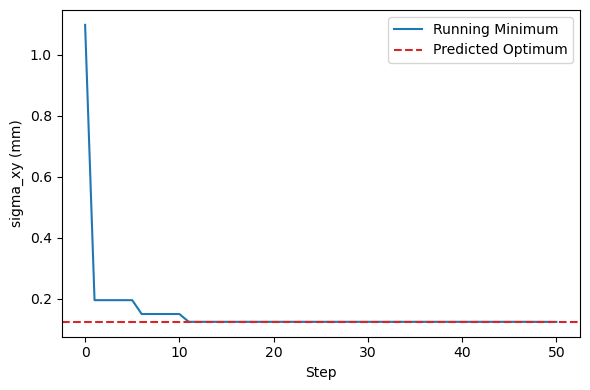

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
ax.plot(x, running_min[n_init - 1:], "C0-", label="Running Minimum")
ax.axhline(y=y_optimum[vocs.objective_names[0]][0], color="C3", linestyle="--", label="Predicted Optimum")
ax.set_xlabel("Step")
ax.set_ylabel(f"{vocs.objective_names[0]} (mm)")
ax.legend()
fig.tight_layout()